In [1]:
    import jsonschema, aiohttp, uritemplate, dataclasses, jsonschema, collections, requests, networkx, pathlib, IPython, ruamel.yaml, \
    inspect, ujson as json, io, ibis, pandas, time, mimetypes, nbformat, aiofiles, aiohttp, nbformat, collections, functools
    from toolz.curried import *
    mime = compose(first, mimetypes.guess_type, str)            
    IPython.display.HTML("""<style>#notebook-container, .container {width: 100%;}</style>""")

In [2]:
    mimetypes.add_type('application/x-ipynb+json', '.ipynb')
    mimetypes.add_type('text/markdown', '.md')
    mimetypes.add_type('text/markdown', '.markdown')
    mimetypes.add_type('application/x-sqlite3', '.sqlite')
    mimetypes.add_type('application/x-yaml', '.yml')
    mimetypes.add_type('application/x-yaml', '.yaml')
    mimetypes.add_type('application/json', '.json')

In [3]:
    class URI(uritemplate.URITemplate, collections.UserList):
        def __init__(self, uri, *data):
            uritemplate.URITemplate.__init__(self, uri), collections.UserList.__init__(self, data or [{}])
            
        def __iter__(self): yield from map(partial(requests.Request, 'get'))(self.expand(**dict) for dict in self.data)

In [4]:
    @dataclasses.dataclass
    class Local:
        glob: str 
        root: pathlib.Path = dataclasses.field(default=pathlib.Path())
        def __iter__(self): yield from self.root.glob(self.glob)            

In [5]:
    async def response(attr, *request, **data):
        """If something has a path to IPython.display.JSON"""
        async with aiohttp.ClientSession() as session:
            for url in map(requests.Request.prepare, request):
                async with session.get(url) as response: data[url] = await getattr(response, attr)()
        return data
    
    async def response_json(*requests): return await response('json', *requests)
    async def response_text(*requests): return await response('text', *requests)

In [6]:
    class Validate:
        def __call__(self, object): return object

In [7]:
    class Schema(jsonschema.Draft4Validator, Validate):
        def validate(self, object):
            try: return super().validate(object) or True
            except jsonschema.ValidationError: return False
        def __hash__(self): return hash(str(self.schema))

In [8]:
    class Mime(collections.UserString, Validate):
        def validate(self, object): 
            if isinstance(object, type(self)): return hash(object) == hash(self)
            return self.data == mime(str(object))
        def __hash__(self): return hash(self.data)

In [9]:
    async def buffer(callable, path):
        async with aiofiles.open(path, mode='r') as file:
            if callable:
                return await callable(file)
            return file
        
    async def local_read(path): return await buffer(operator.methodcaller('read'), path)

In [10]:
    nbschema = nbformat.validator._get_schema_json(nbformat.v4)['$schema']
    jsonschema: nbschema

In [11]:
    array = Schema({'type': 'array', '$schema': __annotations__['jsonschema']})
    object = Schema({'type': 'object', '$schema': __annotations__['jsonschema']})
    string = Schema({'type': 'string', '$schema': __annotations__['jsonschema']})

In [12]:
    compact_source = lambda nb: nb.__setitem__('cells', [object.__setitem__('source', ''.join(object['source'])) or object for object in nb['cells']]) or nb

In [13]:
    def yaml(path):
        import yaml
        with open(path) as file: return yaml.safe_load(file)

In [14]:
Path = type(pathlib.Path(''))
def get_data(x): return x.data

In [42]:
    class Compose(networkx.DiGraph):
        async def advance(self, object, *targets):
            for target in targets:
                paths = sorted(networkx.all_simple_paths(self, type(object), target), key=juxt(compose(flip(isinstance)(Validate), second), compose(len)), reverse=True)
                if not paths: return object
                prior = object
                for this, next, *path in paths:
                    if isinstance(next, Validate):
                        if next.validate(object): this, next, *path = networkx.shortest_path(self, next, target); break
                    else: break
                object = next(object)
                if inspect.isawaitable(object): object = await object
                if type(object) == target: continue
                object = await traverse(self, object, target)      
            return object
        
        async def __call__(self, target, *patterns, **data):
            if not isiterable(target): target = target,
            for pattern in patterns:
                if not isiterable(pattern): pattern = pattern,
                for object in pattern: data[object] = await self.advance(object, *target)
            return data

In [43]:
    graph = Compose()
    graph.add_path([Path, local_read, str, json.loads, array])
    graph.add_path([json.loads, object, dict, pandas.Series])
    graph.add_path([json.loads, array, list])
    graph.add_path([requests.Request, response_text, str])
    graph.add_path([requests.Request, response_json, array, list, IPython.display.JSON])
    graph.add_path([requests.Request, response_json, object, dict, IPython.display.JSON])
    graph.add_path([Path, Mime('application/x-yaml'), yaml])
    graph.add_path([yaml, array])
    graph.add_path([yaml, object])
    graph.add_path([Path, Mime('text/csv'), pandas.read_csv, pandas.DataFrame])
    graph.add_path([Path, Mime('text/markdown'), IPython.display.Markdown, get_data, str])
    graph.add_path([IPython.display.Markdown, get_data, __import__('mistune').markdown, IPython.display.HTML])
    graph.add_path([str, __import__('jinja2').Template])
    graph.add_path([str, __import__('string').Template])
    graph.add_path([dict, pandas.Series, pandas.DataFrame])
    graph.add_path([dict, nbformat.from_dict, compact_source, nbformat.NotebookNode, dict])
    graph.add_path([nbformat.NotebookNode, dict, pandas.Series])
    graph.add_path([IPython.display.HTML, get_data, pandas.read_html, pandas.Series])
    graph.add_path([Path, Mime('text/html'), pandas.read_html])

In [49]:
    pipe(
        await graph(str, Path('ado.ipynb')), valmap(compose(''.join, take(200)))
    )

{PosixPath('fastapi-openapi-context.ipynb'): '{\n "cells": [\n  {\n   "cell_type": "markdown",\n   "metadata": {},\n   "source": [\n    "Generate an openapi spec for anotebook."\n   ]\n  },\n  {\n   "cell_type": "code",\n   "execution_count": 8,\n   "metadat'}

dict

In [52]:
    pipe(
        await graph(dict, Path('ado.ipynb')), valmap(compose(first, get('cells')))
    )

{PosixPath('fastapi-openapi-context.ipynb'): {'cell_type': 'markdown',
  'metadata': {},
  'source': ['Generate an openapi spec for anotebook.']}}

NotebooNode

In [54]:
    pipe(
        await graph(nbformat.NotebookNode, Path('ado.ipynb')), valmap(compose(first, drop(2), operator.attrgetter('cells')))
    )

{PosixPath('fastapi-openapi-context.ipynb'): {'cell_type': 'code',
  'execution_count': 1,
  'metadata': {},
  'outputs': [{'name': 'stderr',
    'output_type': 'stream',
    'text': ['email-validator not installed, email fields will be treated as str.\n',
     'To install, run: pip install email-validator\n']}],
  'source': ['    import fastapi, starlette.testclient, pathlib\n',
   "    if __name__ == '__main__': __import__('nest_asyncio').apply()"]}}

JSON

In [57]:
    await graph(IPython.display.JSON, Path('ado.ipynb'))

{PosixPath('fastapi-openapi-context.ipynb'): <IPython.core.display.JSON object>}

Series

In [58]:
    await graph([dict, nbformat.NotebookNode, pandas.Series], Path('ado.ipynb'))

{PosixPath('fastapi-openapi-context.ipynb'): cells             [{'cell_type': 'markdown', 'metadata': {}, 'so...
 metadata          {'kernelspec': {'display_name': 'p6', 'languag...
 nbformat                                                          4
 nbformat_minor                                                    2
 dtype: object}

DataFrame

In [59]:
    await graph([dict, nbformat.NotebookNode, pandas.DataFrame], Path('ado.ipynb'))

{PosixPath('fastapi-openapi-context.ipynb'):                                                                 0
 cells           [{'cell_type': 'markdown', 'metadata': {}, 'so...
 metadata        {'kernelspec': {'display_name': 'p6', 'languag...
 nbformat                                                        4
 nbformat_minor                                                  2}

Another kind of file

In [63]:
    pipe(await graph(pandas.DataFrame, pathlib.Path('data.csv')), pandas.concat).T

data.csv                                                  \
                    0           1           2           3           4    
Unnamed: 0           0           1           2           3           4   
index       ZRRVgPxAbg  qGdbMygKUl  MFEpsjeg81  Bc5QYEyyvO  HmTeNtf2KE   
A             -1.13811    0.932169   -0.278003   -0.315296    -0.41495   
B            -0.554226   0.0662085    0.804182   -0.558954   -0.107526   
C            -0.303604    -1.12484    0.845789    0.703738   -0.243205   
D            -0.304571     1.18461   -0.477547   -0.816047     0.85921   

                                                                        ...  \
                    5           6           7           8           9   ...   
Unnamed: 0           5           6           7           8           9  ...   
index       64XpwGGKX4  FDGUaeSGrl  9bnZ4FYWx2  AwjEKKungG  NXaBII16Fj  ...   
A             -1.29303   0.0666345    -1.32863     0.86664    0.414605  ...   
B            -0.275852    -1.17587    0.703497    -1.45832    0.481333  ...   
C             -2.29765    0.392907    -1.57246    0.891363    -2.16405  ...   
D            -0.366217   -0.426007    0.137321    -1.17364   -0.597233  ...   

                                                                        \
                    20          21          22          23          24   
Unnamed: 0          20          21          22          23          24   
index       xwTl85EoQF  vXzvHqbkN9  HIVHjSMo0C  2P90ZEkuB4  t78MDAdN8q   
A             0.375973   -0.666088    -1.82705   -0.624332  -0.0506713   
B            -0.327619     1.51967    -1.29964    0.876575   -0.110464   
C            -0.761711     0.84413  -0.0749852     -0.3664   -0.135025   
D          -0.00921832   -0.409743    0.755613     -1.8391    0.340917   

                                                                        
                    25          26          27          28          29  
Unnamed: 0          25          26          27          28          29  
index       twVQDkT4Ml  J3Xm342gpK  A0PPGcOKtR  NnuL0L7diK  Q8ZNWO1pjT  
A             -2.76588    0.682396    -1.15344    0.899535     1.21765  
B              1.14753    0.725946   -0.980484    0.761013    0.424012  
C             -1.64376    -1.62894   -0.145673    0.274579    0.282331  
D              2.17179  -0.0148665    -1.59233    0.278727      1.1311  

[6 rows x 30 columns]

Await a bunch of traversals.

Single path.

In [64]:
    t = time.time()
    l = await graph(pandas.Series, Local('*.ipynb'))
    t = time.time()-t; F"{len(l)} files in {t} seconds"

'444 files in 1.2448608875274658 seconds'

Mixed paths

In [65]:
    t = time.time()
    l = await graph(pandas.Series, Local('*.ipynb'), Local('*.yml'), Local('*.yaml'))
    t = time.time()-t; F"{len(l)} files in {t} seconds"

'448 files in 1.2914831638336182 seconds'

All the data together

In [66]:
    pandas.concat(l).unstack().T

,.travis.yml,2018-06-16-Exploring-past-gist.ipynb,2018-06-16-Generating-untitled-notebooks-by-date.ipynb,2018-06-16-Untitled.ipynb,2018-06-16-mapd-post-Copy1.ipynb,2018-06-16-mapd-post-utilities.ipynb,2018-06-17-NotebookDataFrame.ipynb,2018-06-18-A-minimal-nbconvert-build.ipynb,2018-06-18-Sample-Ibis-Outputs.ipynb,2018-06-18-Untitled.ipynb,...,trashfire.ipynb,tricks.yml,uuuuu.ipynb,vvvvv.ipynb,watch.ipynb,what ever.ipynb,womp-Copy1.ipynb,womp.ipynb,zero.ipynb,Δ.ipynb
@vocab,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cells,NaN,"[{'cell_type': 'code', 'execution_count': None...","[{'cell_type': 'markdown', 'metadata': {}, 'so...","[{'cell_type': 'code', 'execution_count': 62, ...","[{'cell_type': 'markdown', 'metadata': {}, 'so...","[{'cell_type': 'markdown', 'metadata': {}, 'so...","[{'cell_type': 'code', 'execution_count': 1, '...","[{'cell_type': 'code', 'execution_count': 92, ...","[{'cell_type': 'markdown', 'metadata': {}, 'so...","[{'cell_type': 'code', 'execution_count': 98, ...",...,"[{'cell_type': 'code', 'execution_count': 6, '...",NaN,"[{'cell_type': 'code', 'execution_count': 1, '...","[{'cell_type': 'code', 'execution_count': 1, '...","[{'cell_type': 'markdown', 'metadata': {}, 'so...","[{'cell_type': 'markdown', 'metadata': {}, 'so...","[{'cell_type': 'code', 'execution_count': 1, '...","[{'cell_type': 'code', 'execution_count': 1, '...","[{'cell_type': 'markdown', 'metadata': {}, 'so...","[{'cell_type': 'code', 'execution_count': 1562..."
channels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dependencies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deploy,"{'provider': 'pypi', 'user': 'docfast', 'passw...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
install,"[python setup.py sdist bdist_wheel, pip instal...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
language,python,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
metadata,NaN,"{'kernelspec': {'display_name': 'p6', 'languag...","{'kernelspec': {'display_name': 'p6', 'languag...","{'kernelspec': {'display_name': 'p6', 'languag...","{'kernelspec': {'display_name': 'p6', 'languag...","{'kernelspec': {'display_name': 'p6', 'languag...","{'kernelspec': {'display_name': 'p6', 'languag...","{'kernelspec': {'display_name': 'p6', 'languag...","{'kernelspec': {'display_name': 'p6', 'languag...","{'kernelspec': {'display_name': 'p6', 'languag...",...,"{'kernelspec': {'display_name': 'p6', 'languag...",NaN,"{'kernelspec': {'display_name': 'p6', 'languag...","{'kernelspec': {'display_name': 'p6', 'languag...","{'kernelspec': {'display_name': 'p6', 'languag...","{'kernelspec': {'display_name': 'p6', 'languag...","{'kernelspec': {'display_name': 'p6', 'languag...","{'kernelspec': {'display_name': 'p6', 'languag...","{'kernelspec': {'display_name': 'p6', 'languag...","{'kernelspec': {'display_name': 'p6', 'languag..."
n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The transforms

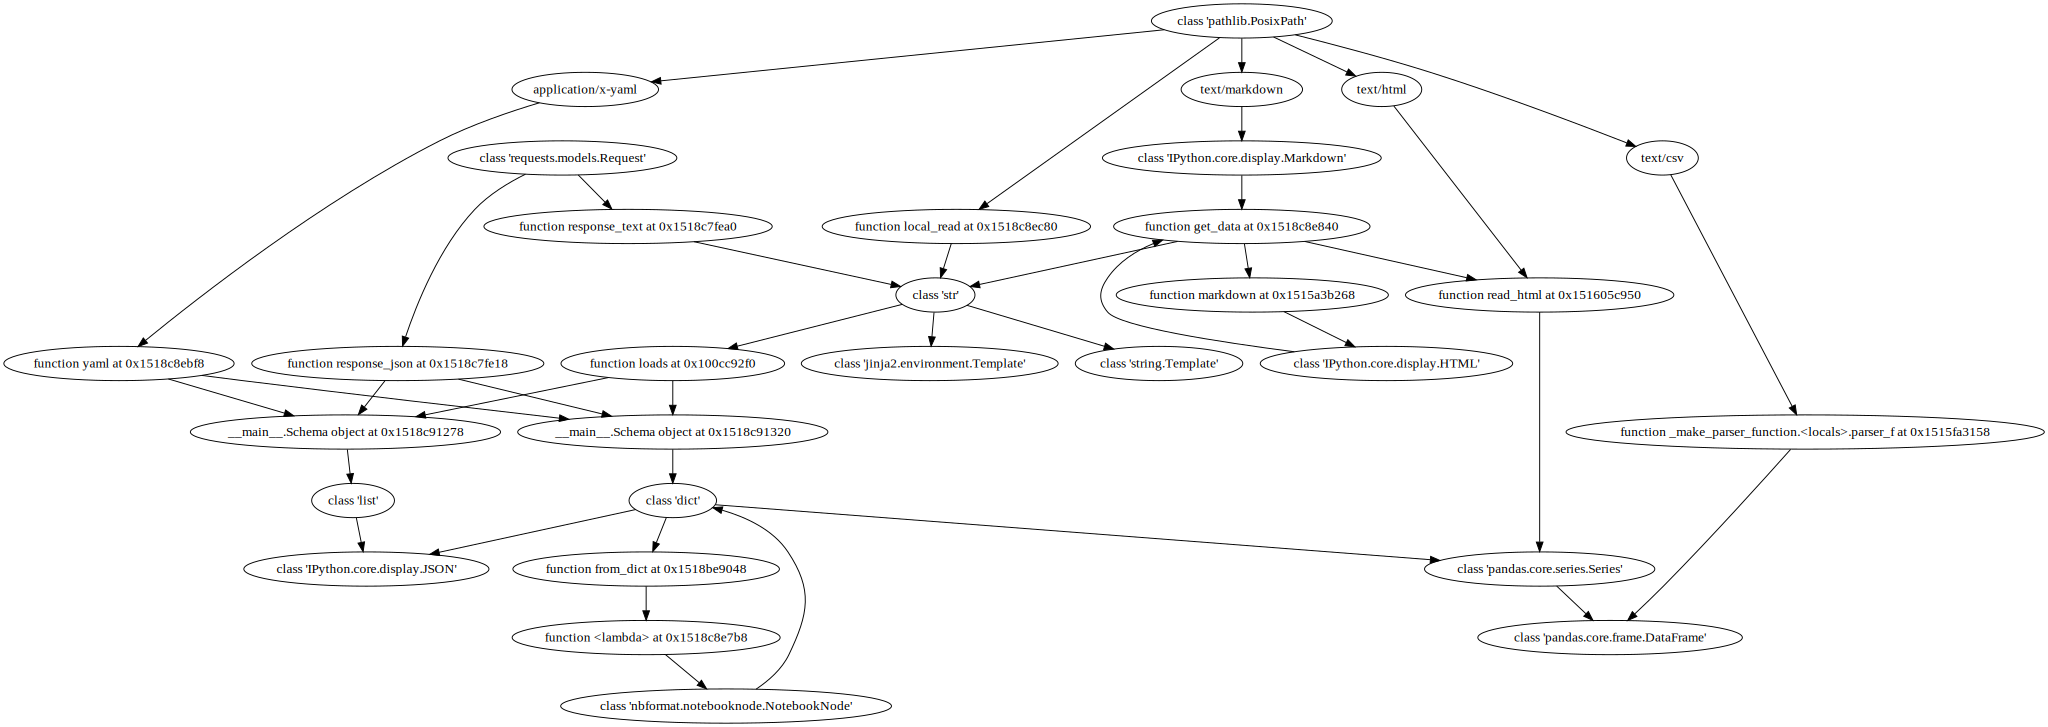

In [67]:
    __import__('graphviz').Source(networkx.nx_pydot.to_pydot(graph).create_dot().decode('utf-8'))